In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from gproc.elliptic import ess_samples_probit
from gproc.metropolis_hastings import mh, mh_step
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit, chol_inverse
from gproc.approx_marginal_is import importance_sampler
from gproc.joint_sampler import joint_sampler

In [2]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
y, prob_y, f = sample_at_x(x, kernel_fcn = squared_exponential, kernel_params = {'lengthscale': true_lengthscale, 'variance': true_variance})

lap_kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

gram = lap_kernel.make_gram(x, x)
inverse_gram = chol_inverse(gram)

In [3]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-37.53071561972133

In [4]:
Kernel = SquaredExponential
th_0 = np.array([np.log(true_lengthscale), np.log(true_variance)])
f_arr, th_arr, marg_arr, move_arr, acc_rate_hist, cov_scale_hist, inverse_gram_arr = joint_sampler(5000, y, x, Kernel, th_0, marg_0, cov=np.eye(th_0.shape[0]), N_imp=64, hyper_burn_in=1000, ess_burn_in=1, verbose=True)

Sampling hyperparameters


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.02it/s]


Burning in proposal latent function for ELL-SS algorithm
Sampling latent functions


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 716.73it/s]


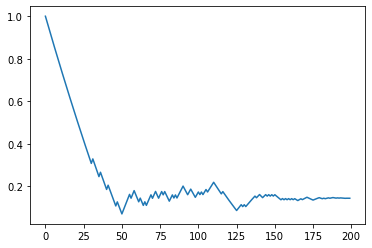

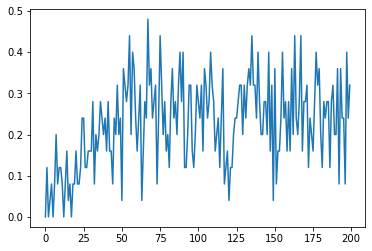

In [5]:
plt.plot(cov_scale_hist)
plt.show()
plt.plot(acc_rate_hist)
plt.show()

Acceptance rate = 22.84


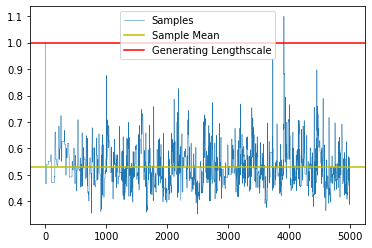

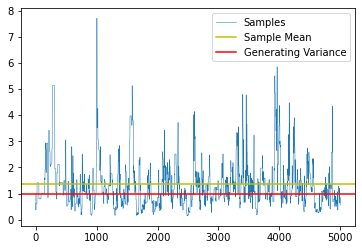

In [6]:
print(f'Acceptance rate = {move_arr.mean()*100}')

plt.plot(np.exp(th_arr[:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_lengthscale, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = true_variance, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()

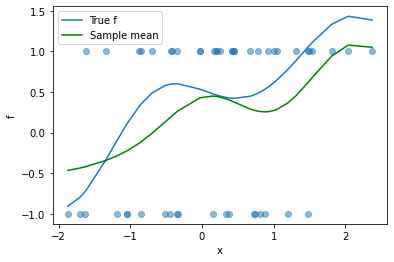

In [7]:
sort_ix = np.argsort(x.reshape(-1))

plt.xlabel('x')
plt.ylabel('f')
for i in range(f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()

In [8]:
from gproc.pseudo_marginal_prediction import pm_predict

#pm_predict(np.array([0.0]), x, y, SquaredExponential, f_arr, th_arr, inverse_gram_arr)
pred_xs = np.linspace(-2.5,1.5,100).reshape((100,1))
pred_probs = np.empty(100)
for i in tqdm(range(100)):
    pred_probs[i] = pm_predict(pred_xs[i,:], x, y, SquaredExponential, f_arr, th_arr, inverse_gram_arr)
    


  0%|          | 0/100 [00:00<?, ?it/s]

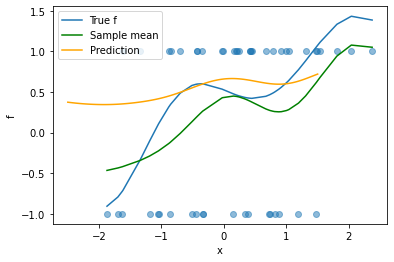

In [9]:
plt.xlabel('x')
plt.ylabel('f')
for i in range(f_arr.shape[0], 100):
    plt.plot(x[sort_ix], f_arr[i, :][sort_ix], c = 'r', linewidth = 0.1, alpha = 0.8)
    
plt.plot(x[sort_ix], f[sort_ix], label='True f')
plt.plot(x[sort_ix], f_arr.mean(axis = 0)[sort_ix], c='g', label='Sample mean')
plt.plot(pred_xs, pred_probs, c='orange', label="Prediction")
plt.scatter(x, y, alpha=0.5)

plt.legend()
plt.show()

In [10]:
pred_probs

array([0.37458926, 0.37076123, 0.3671633 , 0.36381545, 0.36073339,
       0.35792793, 0.35540487, 0.35316561, 0.35120822, 0.34952918,
       0.34812519, 0.34699498, 0.34614048, 0.34556725, 0.34528393,
       0.34530095, 0.34562883, 0.34627639, 0.34724933, 0.34854931,
       0.35017374, 0.35211619, 0.35436752, 0.35691727, 0.35975539,
       0.36287379, 0.36626773, 0.36993679, 0.37388542, 0.37812314,
       0.38266441, 0.38752821, 0.39273739, 0.3983178 , 0.40429717,
       0.41070366, 0.4175643 , 0.42490316, 0.43273954, 0.44108609,
       0.44994714, 0.45931721, 0.4691798 , 0.47950653, 0.49025673,
       0.5013774 , 0.51280366, 0.52445958, 0.5362594 , 0.54810894,
       0.55990736, 0.57154892, 0.58292516, 0.59392705, 0.60444748,
       0.61438357, 0.62363907, 0.63212638, 0.63976823, 0.64649891,
       0.65226515, 0.65702659, 0.66075604, 0.66343964, 0.66507699,
       0.66568135, 0.66527994, 0.6639144 , 0.66164124, 0.65853225,
       0.65467475, 0.65017134, 0.6451392 , 0.63970871, 0.63402